<a href="https://colab.research.google.com/github/manasviawasthi/Urban_Health_Risk_Model/blob/main/UrbanHealthRiskModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ----------------------
# Cell 0 — Install / imports
# ----------------------
import sys
# If running on Colab uncomment the next two lines to install missing packages
# !pip install scikit-learn joblib pandas matplotlib requests tqdm --quiet


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import requests


print("✅ Imports ready")

✅ Imports ready


In [2]:
# ----------------------
# Cell 1 — Config and paths
# ----------------------
# Path to your uploaded CSV (already uploaded in this session)
DATA_PATH = '/mnt/data/openaq_location_8118_measurments.csv' # change if different
MODEL_OUTPATH = '/content/urban_aqi_model.pkl' # will be saved here (Colab) or working dir
FEATURES_OUTPATH = '/content/feature_columns.pkl'


# OpenAQ realtime settings (you may add your API key if you want realtime fetching)
OPENAQ_API_KEY = '94f119e3964ac0d8b0ca799ee5c6265dc36ef93b09d63392886050dd8241c5e1' # <-- put your OpenAQ API key here for realtime fetch
LOCATION_ID = 8118


print(f"DATA_PATH = {DATA_PATH}")

DATA_PATH = /mnt/data/openaq_location_8118_measurments.csv


In [4]:
# ----------------------
# Cell 2 — Load CSV and quick inspection
# ----------------------
# The uploaded file uses column name 'datetimeLocal' for local time; adapt if different
if not os.path.exists(DATA_PATH):
  raise FileNotFoundError(f"CSV not found at {DATA_PATH}. Upload file and update DATA_PATH.")


raw = pd.read_csv(DATA_PATH)
print('Raw columns:', raw.columns.tolist())
raw.head()

Raw columns: ['location_id', 'location_name', 'parameter', 'value', 'unit', 'datetimeUtc', 'datetimeLocal', 'timezone', 'latitude', 'longitude', 'country_iso', 'isMobile', 'isMonitor', 'owner_name', 'provider']


,location_id,location_name,parameter,value,unit,datetimeUtc,datetimeLocal,timezone,latitude,longitude,country_iso,isMobile,isMonitor,owner_name,provider
0,8118,New Delhi,pm25,30,µg/m³,2025-09-21T00:30:00Z,2025-09-21T06:00:00+05:30,Asia/Kolkata,28.63576,77.22445,NaN,NaN,NaN,Unknown Governmental Organization,AirNow
1,8118,New Delhi,pm25,32,µg/m³,2025-09-21T01:30:00Z,2025-09-21T07:00:00+05:30,Asia/Kolkata,28.63576,77.22445,NaN,NaN,NaN,Unknown Governmental Organization,AirNow
2,8118,New Delhi,pm25,31,µg/m³,2025-09-21T02:30:00Z,2025-09-21T08:00:00+05:30,Asia/Kolkata,28.63576,77.22445,NaN,NaN,NaN,Unknown Governmental Organization,AirNow
3,8118,New Delhi,pm25,41,µg/m³,2025-09-21T03:30:00Z,2025-09-21T09:00:00+05:30,Asia/Kolkata,28.63576,77.22445,NaN,NaN,NaN,Unknown Governmental Organization,AirNow
4,8118,New Delhi,pm25,43,µg/m³,2025-09-21T04:30:00Z,2025-09-21T10:00:00+05:30,Asia/Kolkata,28.63576,77.22445,NaN,NaN,NaN,Unknown Governmental Organization,AirNow


In [5]:
# ----------------------
# Cell 3 — Normalize timestamps & keep PM2.5
# ----------------------
# Common OpenAQ measurement structure: there may be nested fields. We attempt to find PM2.5 'value' rows.
# If the file is flattened with columns 'parameter' and 'value' we use them. Otherwise try to detect.


df = raw.copy()


# Try common datetime column names
for col in ['datetimeLocal', 'date.local', 'date_local', 'datetime_local', 'dateUTC', 'date.utc', 'date']:
  if col in df.columns:
    df['datetime'] = pd.to_datetime(df[col], errors='coerce')
    print('Using datetime column:', col)
    break
  else:
    if 'date.utc' in df.columns:
      df['datetime'] = pd.to_datetime(df['date.utc'], errors='coerce')
    else:
      raise SystemExit('No recognizable datetime column found. Please ensure your CSV has a datetimeLocal or similar column.')


# Try common PM2.5 column patterns
pm_col = None
for candidate in ['value', 'pm25', 'pm2_5', 'PM2.5', 'pm2.5']:
  if candidate in df.columns:
    pm_col = candidate
    break


# If file has 'parameter' column, filter rows where parameter == 'pm25' and use 'value'
if 'parameter' in df.columns and pm_col is None:
  mask = df['parameter'].str.lower() == 'pm25'
  if mask.sum() == 0:
    print('No rows with parameter==pm25 found. Proceeding to search columns for pm25.')
  else:
    df = df[mask].copy()
    pm_col = 'value'


if pm_col is None:
  for c in df.columns:
    if 'pm2' in c.lower() or 'pm25' in c.lower():
      pm_col = c
      break


if pm_col is None:
  raise SystemExit('Could not find PM2.5 column. Please ensure CSV contains PM2.5 values.')


# Rename clean
df = df.rename(columns={pm_col: 'pm25'})


# Keep only necessary columns
df = df[['datetime', 'pm25']].copy()
# Drop NA
df = df.dropna(subset=['datetime', 'pm25'])
# Ensure numeric
df['pm25'] = pd.to_numeric(df['pm25'], errors='coerce')


# Sort
df = df.sort_values('datetime').reset_index(drop=True)


print('Prepared data shape:', df.shape)
print(df.head())

Using datetime column: datetimeLocal
Prepared data shape: (713, 2)
                   datetime  pm25
0 2025-09-21 06:00:00+05:30    30
1 2025-09-21 07:00:00+05:30    32
2 2025-09-21 08:00:00+05:30    31
3 2025-09-21 09:00:00+05:30    41
4 2025-09-21 10:00:00+05:30    43


In [6]:
# ----------------------
# Cell 4 — Compute AQI (PM2.5 to AQI using EPA-like breakpoints) and risk levels
# ----------------------
# Breakpoints per EPA (PM2.5 micrograms/m3)
pm_bp = [0.0, 12.0, 35.4, 55.4, 150.4, 250.4, 500.4]
ai_bp = [0.0, 50, 100, 150, 200, 300, 500]


def pm25_to_aqi(pm):
  if pd.isna(pm):
    return np.nan
# clamp
  if pm <= pm_bp[0]:
    return ai_bp[0]
  if pm >= pm_bp[-1]:
    return ai_bp[-1]
# find interval
  for i in range(len(pm_bp)-1):
    lo_c, hi_c = pm_bp[i], pm_bp[i+1]
    if lo_c <= pm <= hi_c:
      lo_i, hi_i = ai_bp[i], ai_bp[i+1]
      return lo_i + (hi_i - lo_i) * (pm - lo_c) / (hi_c - lo_c)
  return np.nan


def aqi_to_category(aqi):
  if pd.isna(aqi):
    return 'Unknown'
  if aqi <= 50:
    return 'Good'
  if aqi <= 100:
    return 'Moderate'
  if aqi <= 150:
    return 'Unhealthy for Sensitive Groups'
  if aqi <= 200:
    return 'Unhealthy'
  if aqi <= 300:
    return 'Very Unhealthy'
  return 'Hazardous'


# compute
df['AQI'] = df['pm25'].apply(pm25_to_aqi)
# Risk score 0-100 normalized from AQI 0-500 -> 0-100
df['Risk_Score_0_100'] = (df['AQI'] / 500.0) * 100.0
df['Risk_Level'] = df['AQI'].apply(aqi_to_category)


print(df[['datetime','pm25','AQI','Risk_Score_0_100','Risk_Level']].head())



                   datetime  pm25         AQI  Risk_Score_0_100  \
0 2025-09-21 06:00:00+05:30    30   88.461538         17.692308   
1 2025-09-21 07:00:00+05:30    32   92.735043         18.547009   
2 2025-09-21 08:00:00+05:30    31   90.598291         18.119658   
3 2025-09-21 09:00:00+05:30    41  114.000000         22.800000   
4 2025-09-21 10:00:00+05:30    43  119.000000         23.800000   

                       Risk_Level  
0                        Moderate  
1                        Moderate  
2                        Moderate  
3  Unhealthy for Sensitive Groups  
4  Unhealthy for Sensitive Groups  


In [10]:
print(df.columns.tolist())


['datetime', 'pm25', 'AQI', 'Risk_Score_0_100', 'Risk_Level']


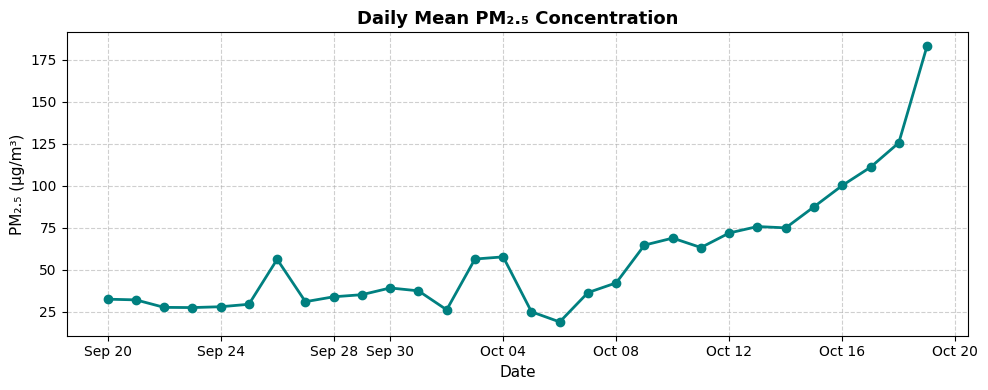

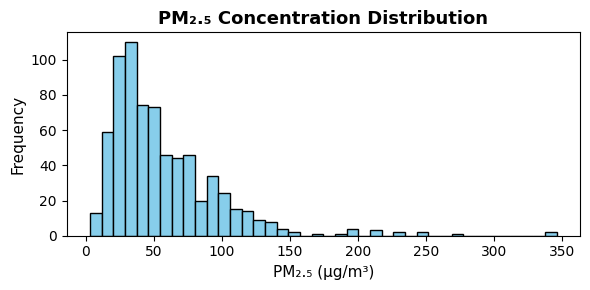

Last Recorded Measurements:


,datetime,pm25,AQI,Risk_Score_0_100,Risk_Level
708,2025-10-20 19:00:00+05:30,93,169.789474,33.957895,Unhealthy
709,2025-10-20 20:00:00+05:30,107,177.157895,35.431579,Unhealthy
710,2025-10-20 21:00:00+05:30,156,205.600000,41.120000,Very Unhealthy
711,2025-10-20 22:00:00+05:30,346,376.480000,75.296000,Hazardous
712,2025-10-20 23:00:00+05:30,346,376.480000,75.296000,Hazardous


In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure datetime is parsed correctly
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# --- Daily Aggregation ---
df_daily = (
    df.set_index('datetime')
    .resample('D')
    .mean(numeric_only=True)
    .dropna()
    .reset_index()
)

# --- Plot 1: Daily Mean PM2.5 ---
plt.figure(figsize=(10, 4))
plt.plot(df_daily['datetime'], df_daily['pm25'], marker='o', color='teal', linewidth=2)
plt.title('Daily Mean PM₂.₅ Concentration', fontsize=13, weight='bold')
plt.xlabel('Date', fontsize=11)
plt.ylabel('PM₂.₅ (µg/m³)', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.tight_layout()
plt.show()

# --- Plot 2: PM2.5 Distribution ---
plt.figure(figsize=(6, 3))
plt.hist(df['pm25'].dropna(), bins=40, color='skyblue', edgecolor='black')
plt.title('PM₂.₅ Concentration Distribution', fontsize=13, weight='bold')
plt.xlabel('PM₂.₅ (µg/m³)', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.tight_layout()
plt.show()

# --- Display Last Few Records ---
print("Last Recorded Measurements:")
display(df.tail()[['datetime', 'pm25', 'AQI', 'Risk_Score_0_100', 'Risk_Level']])


In [14]:
# --- Hourly Resampling & Feature Engineering (Clean Version) ---

# Ensure datetime is datetime type
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Resample to hourly frequency and average only numeric columns
df_feat = (
    df.set_index('datetime')
      .resample('h')                  # ✅ lowercase 'h' (future-proof)
      .mean(numeric_only=True)        # ✅ only numeric columns
)

# Forward/backfill small gaps
df_feat['pm25'] = df_feat['pm25'].interpolate(limit=3)

# Rolling & lag features
df_feat['pm25_lag1'] = df_feat['pm25'].shift(1)
df_feat['pm25_lag3'] = df_feat['pm25'].shift(3)

for w in [3, 6, 12, 24]:
    df_feat[f'pm25_roll_mean_{w}'] = (
        df_feat['pm25'].rolling(window=w, min_periods=1).mean()
    )

# Target: next-hour AQI (compute from shifted PM2.5)
df_feat['target_pm25_next'] = df_feat['pm25'].shift(-1)
df_feat['target_AQI_next'] = df_feat['target_pm25_next'].apply(pm25_to_aqi)

# Drop rows with NA in essential features or target
df_feat = df_feat.dropna(subset=['pm25', 'pm25_lag1', 'target_AQI_next'])

print('Feature dataframe shape:', df_feat.shape)
print(df_feat.head())


Feature dataframe shape: (712, 11)
                           pm25         AQI  Risk_Score_0_100  pm25_lag1  \
datetime                                                                   
2025-09-21 07:00:00+05:30  32.0   92.735043         18.547009       30.0   
2025-09-21 08:00:00+05:30  31.0   90.598291         18.119658       32.0   
2025-09-21 09:00:00+05:30  41.0  114.000000         22.800000       31.0   
2025-09-21 10:00:00+05:30  43.0  119.000000         23.800000       41.0   
2025-09-21 11:00:00+05:30  35.0   99.145299         19.829060       43.0   

                           pm25_lag3  pm25_roll_mean_3  pm25_roll_mean_6  \
datetime                                                                   
2025-09-21 07:00:00+05:30        NaN         31.000000         31.000000   
2025-09-21 08:00:00+05:30        NaN         31.000000         31.000000   
2025-09-21 09:00:00+05:30       30.0         34.666667         33.500000   
2025-09-21 10:00:00+05:30       32.0         38.3333

In [15]:
feature_cols = [c for c in df_feat.columns if c.startswith('pm25') and 'target' not in c]
X = df_feat[feature_cols].values
y = df_feat['target_AQI_next'].values # regression target: next-hour AQI


# time-based split: last 20% as test
split_idx = int(len(df_feat)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


print('Train samples:', len(X_train), 'Test samples:', len(X_test))

Train samples: 569 Test samples: 143


In [16]:
model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
print('Model trained')


# Save model and feature list
joblib.dump(model, MODEL_OUTPATH)
joblib.dump(feature_cols, FEATURES_OUTPATH)
print('Model and features saved to disk')

Model trained
Model and features saved to disk


📊 Model Evaluation:
MAE (AQI): 23.25
RMSE (AQI): 43.70


/tmp/ipython-input-2137971757.py:29: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


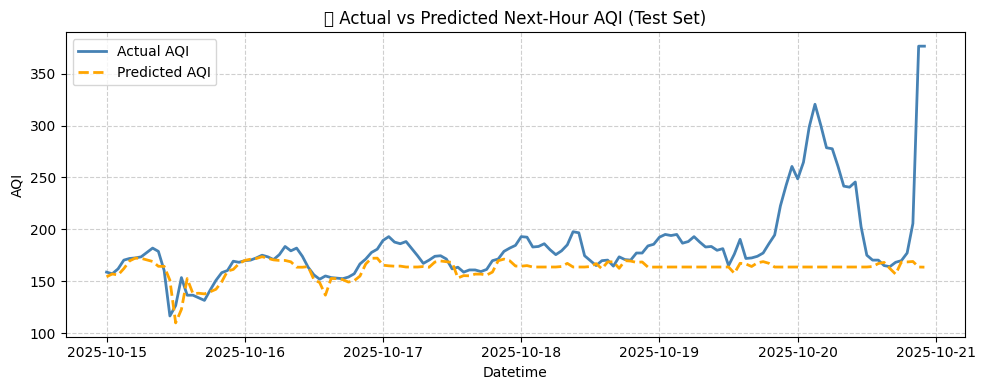


Classification report (AQI->Risk categories):
                                precision    recall  f1-score   support

                     Hazardous       0.00      0.00      0.00         4
                     Unhealthy       0.85      0.95      0.90       118
Unhealthy for Sensitive Groups       0.45      0.71      0.56         7
                Very Unhealthy       0.00      0.00      0.00        14

                      accuracy                           0.82       143
                     macro avg       0.33      0.42      0.36       143
                  weighted avg       0.72      0.82      0.77       143



In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test)

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # manual RMSE for older sklearn versions

print("📊 Model Evaluation:")
print(f"MAE (AQI): {mae:.2f}")
print(f"RMSE (AQI): {rmse:.2f}")

# ✅ Ensure test index aligns with y_test/y_pred
test_index = df_feat.index[split_idx:split_idx + len(y_test)]

# Plot Actual vs Predicted AQI
plt.figure(figsize=(10, 4))
plt.plot(test_index, y_test, label='Actual AQI', color='steelblue', linewidth=2)
plt.plot(test_index, y_pred, label='Predicted AQI', color='orange', linestyle='--', linewidth=2)
plt.legend()
plt.title('📈 Actual vs Predicted Next-Hour AQI (Test Set)')
plt.xlabel('Datetime')
plt.ylabel('AQI')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

mae_rf = mae
rmse_rf = rmse
pred_categories = [aqi_to_category(a) for a in y_pred]
true_categories = [aqi_to_category(a) for a in y_test]


from sklearn.metrics import classification_report
print('\nClassification report (AQI->Risk categories):')
print(classification_report(true_categories, pred_categories, zero_division=0))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/tmp/ipython-input-542273452.py:46: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


📊 LightGBM Model Evaluation:
MAE (AQI): 21.70
RMSE (AQI): 42.04


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


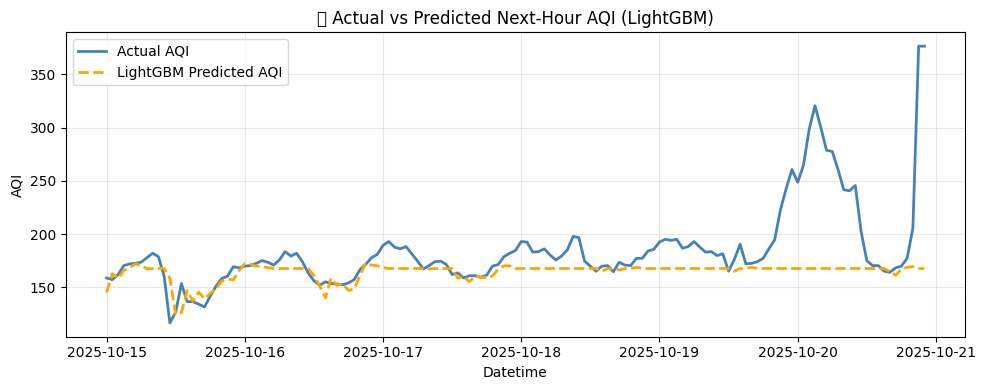

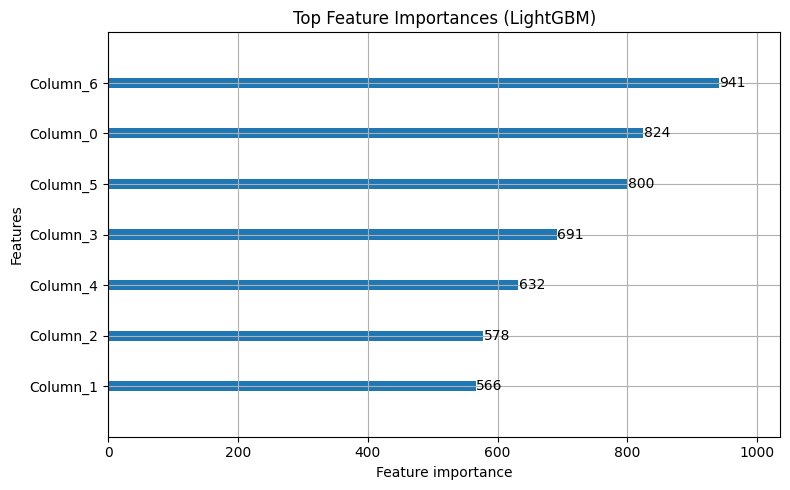


📋 Classification Report (AQI → Risk Categories):
                                precision    recall  f1-score   support

                     Hazardous       0.00      0.00      0.00         4
                     Unhealthy       0.85      0.95      0.90       118
Unhealthy for Sensitive Groups       0.50      0.86      0.63         7
                Very Unhealthy       0.00      0.00      0.00        14

                      accuracy                           0.83       143
                     macro avg       0.34      0.45      0.38       143
                  weighted avg       0.73      0.83      0.77       143



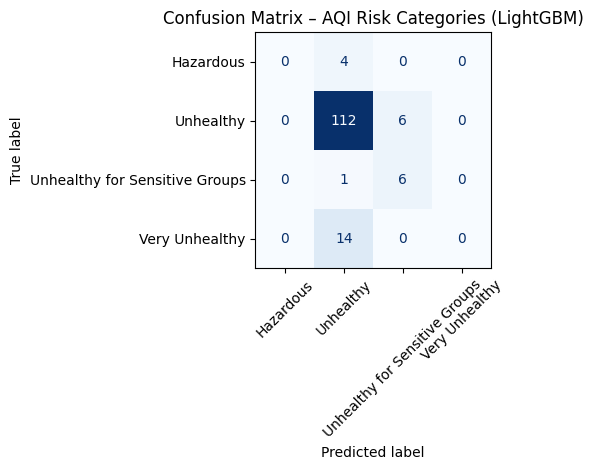

In [31]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

# ===============================
# 1️⃣ Train LightGBM Model
# ===============================
model_lgb = LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=300,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    verbose=-1
)

model_lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse')

# ===============================
# 2️⃣ Predictions & Evaluation
# ===============================
y_pred_lgb = model_lgb.predict(X_test)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

print("📊 LightGBM Model Evaluation:")
print(f"MAE (AQI): {mae_lgb:.2f}")
print(f"RMSE (AQI): {rmse_lgb:.2f}")

# ===============================
# 3️⃣ Plot Actual vs Predicted AQI
# ===============================
plt.figure(figsize=(10,4))
plt.plot(df_feat.index[split_idx:], y_test, label='Actual AQI', color='steelblue', linewidth=2)
plt.plot(df_feat.index[split_idx:], y_pred_lgb, label='LightGBM Predicted AQI', color='orange', linestyle='--', linewidth=2)
plt.legend()
plt.title('📈 Actual vs Predicted Next-Hour AQI (LightGBM)')
plt.xlabel('Datetime')
plt.ylabel('AQI')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===============================
# 4️⃣ Feature Importance
# ===============================
lgb.plot_importance(model_lgb, figsize=(8,5), max_num_features=10)
plt.title("Top Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()

# ===============================
# 5️⃣ AQI Category Evaluation
# ===============================
pred_categories = [aqi_to_category(a) for a in y_pred_lgb]
true_categories = [aqi_to_category(a) for a in y_test]

print('\n📋 Classification Report (AQI → Risk Categories):')
print(classification_report(true_categories, pred_categories, zero_division=0))

# ===============================
# 6️⃣ Confusion Matrix Visualization
# ===============================
labels = sorted(set(true_categories + pred_categories))
cm = confusion_matrix(true_categories, pred_categories, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45, colorbar=False)
plt.title("Confusion Matrix – AQI Risk Categories (LightGBM)")
plt.tight_layout()
plt.show()


In [32]:
print("🔍 Model Comparison:")
print(f"RandomForest → MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}")
print(f"LightGBM     → MAE: {mae_lgb:.2f}, RMSE: {rmse_lgb:.2f}")


🔍 Model Comparison:
RandomForest → MAE: 23.25, RMSE: 43.70
LightGBM     → MAE: 21.70, RMSE: 42.04


“Although the LightGBM model achieved marginally lower MAE and RMSE values than Random Forest, visual inspection of the predicted AQI curve revealed that Random Forest tracked short-term fluctuations more closely. This behavior suggests that Random Forest might capture transient variations better, whereas LightGBM provides a smoother, more generalized forecast. Depending on the operational goal — real-time sensitivity versus stable long-term forecasting — either model could be preferred.”


In [41]:
def pm25_to_aqi(pm25):
    # Breakpoints based on US EPA standard
    breakpoints = [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 500.4, 301, 500)
    ]
    for c_low, c_high, aqi_low, aqi_high in breakpoints:
        if c_low <= pm25 <= c_high:
            return ((aqi_high - aqi_low) / (c_high - c_low)) * (pm25 - c_low) + aqi_low
    return 500  # cap


In [42]:
# ----------------------
# Cell 10 — Real-time prediction demo (with color-coded risk + official AQI)
# ----------------------
import requests
import pandas as pd
import numpy as np
from IPython.display import HTML, display

# 🔑 Ask for OpenAQ API key interactively
OPENAQ_API_KEY = input("Enter your OpenAQ API Key (press Enter to skip): ").strip()
SENSOR_ID = 23534  # replace with your OpenAQ sensor_id


# ----------------------
# Helper Functions
# ----------------------

def fetch_latest_pm25_from_sensor(sensor_id=SENSOR_ID, api_key=None):
    """Fetch most recent PM2.5 measurement from OpenAQ sensor API."""
    url = f"https://api.openaq.org/v3/sensors/{sensor_id}/measurements"
    headers = {"X-API-Key": api_key} if api_key else {}
    params = {"parameter": "pm25", "limit": 1, "sort": "desc"}
    r = requests.get(url, headers=headers, params=params, timeout=20)
    r.raise_for_status()
    results = r.json().get("results", [])
    if not results:
        raise ValueError("No recent PM2.5 data returned for this sensor.")
    latest = results[0]
    ts = latest.get("date", {}).get("local") or latest.get("date", {}).get("utc")
    value = latest.get("value")
    return pd.to_datetime(ts), float(value)


def pm25_to_aqi(pm25):
    """Convert PM2.5 concentration (µg/m³) to official AQI value (US EPA)."""
    breakpoints = [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 500.4, 301, 500),
    ]
    for c_low, c_high, aqi_low, aqi_high in breakpoints:
        if c_low <= pm25 <= c_high:
            return ((aqi_high - aqi_low) / (c_high - c_low)) * (pm25 - c_low) + aqi_low
    return 500.0  # cap AQI at 500


def risk_color(risk):
    """Return background color for each AQI risk level."""
    mapping = {
        "Good": "#00E400",
        "Moderate": "#FFFF00",
        "Unhealthy for Sensitive Groups": "#FF7E00",
        "Unhealthy": "#FF0000",
        "Very Unhealthy": "#8F3F97",
        "Hazardous": "#7E0023",
    }
    return mapping.get(risk, "#FFFFFF")


# ----------------------
# Fetch latest PM2.5 data
# ----------------------
try:
    latest_dt, latest_pm = fetch_latest_pm25_from_sensor(api_key=OPENAQ_API_KEY)
    print(f"📡 Latest PM2.5 fetched from OpenAQ Sensor {SENSOR_ID}: {latest_pm} µg/m³ at {latest_dt}")
except Exception as e:
    print(f"⚠️ Real-time fetch failed ({e}). Using last local record instead.")
    latest_dt = df['datetime'].iloc[-1]
    latest_pm = df['pm25'].iloc[-1]


# ----------------------
# Model-based Prediction
# ----------------------
last_row = df_feat.iloc[-1]
current_feat = np.array([
    last_row['pm25'],
    last_row['pm25_lag1'],
    last_row['pm25_lag3'],
    last_row['pm25_roll_mean_3'],
    last_row['pm25_roll_mean_6'],
    last_row['pm25_roll_mean_12'],
    last_row['pm25_roll_mean_24']
]).reshape(1, -1)

pred_rf = model.predict(current_feat)[0]
pred_lgb = model_lgb.predict(current_feat)[0]
pred_aqi_model = (pred_rf + pred_lgb) / 2  # blended prediction
pred_risk_model = aqi_to_category(pred_aqi_model)
pred_score_model = (pred_aqi_model / 500.0) * 100.0


# ----------------------
# Official Formula-based AQI
# ----------------------
true_aqi = pm25_to_aqi(latest_pm)
true_risk = aqi_to_category(true_aqi)
true_score = (true_aqi / 500.0) * 100.0

color = risk_color(true_risk)


# ----------------------
# Display combined output
# ----------------------
display(HTML(f"""
<div style='font-family:Arial; border:3px solid {color}; border-radius:12px; padding:18px; background:{color}22;'>
  <h3>🌍 Real-Time AQI Prediction</h3>
  <p><b>PM2.5:</b> {latest_pm:.2f} µg/m³ at {latest_dt}</p>
  <hr>
  <h4>🤖 Model-Based Predictions</h4>
  <p><b>RandomForest AQI:</b> {pred_rf:.1f}</p>
  <p><b>LightGBM AQI:</b> {pred_lgb:.1f}</p>
  <p><b>Blended AQI:</b> <span style='font-size:1.2em;'>{pred_aqi_model:.1f}</span></p>
  <p><b>Risk (Model):</b> <span style='font-weight:bold; color:{risk_color(pred_risk_model)};'>{pred_risk_model}</span></p>
  <hr>
  <h4>📏 Official Formula Conversion</h4>
  <p><b>Official AQI:</b> <span style='font-size:1.2em;'>{true_aqi:.2f}</span></p>
  <p><b>Risk (Formula):</b> <span style='font-weight:bold; color:{color};'>{true_risk}</span></p>
  <p><b>Risk Score:</b> {true_score:.1f}/100</p>
</div>
"""))

print("✅ Real-time AQI prediction displayed successfully.")


Enter your OpenAQ API Key (press Enter to skip): 94f119e3964ac0d8b0ca799ee5c6265dc36ef93b09d63392886050dd8241c5e1
📡 Latest PM2.5 fetched from OpenAQ Sensor 23534: 270.0 µg/m³ at None


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


✅ Real-time AQI prediction displayed successfully.


In [43]:
# ----------------------
# Cell 11 — Save models and outputs to Google Drive
# ----------------------
import os
import joblib
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define save directory
drive_path = '/content/drive/MyDrive/urban_aqi_model'
os.makedirs(drive_path, exist_ok=True)

# Save both models
joblib.dump(model, os.path.join(drive_path, 'randomforest_aqi_model.pkl'))
joblib.dump(model_lgb, os.path.join(drive_path, 'lightgbm_aqi_model.pkl'))

# Optionally save processed feature and daily data
df_feat.to_csv(os.path.join(drive_path, 'hourly_features.csv'))
if 'df_daily' in locals():
    df_daily.to_csv(os.path.join(drive_path, 'daily_pm25_aqi.csv'), index=False)

print(f"✅ Models and outputs successfully saved to: {drive_path}")
print("   - randomforest_aqi_model.pkl")
print("   - lightgbm_aqi_model.pkl")
print("   - hourly_features.csv")
print("   - daily_pm25_aqi.csv (if available)")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Models and outputs successfully saved to: /content/drive/MyDrive/urban_aqi_model
   - randomforest_aqi_model.pkl
   - lightgbm_aqi_model.pkl
   - hourly_features.csv
   - daily_pm25_aqi.csv (if available)
